# Loading Data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time

from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
from torchvision.datasets import CIFAR10

In [2]:
def get_dataset(train):
    data = CIFAR10('.', train=train, download=True)
    return data.data, data.targets

In [3]:
(x, y), (test_X, test_y) = get_dataset(True), get_dataset(False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_size = 40000

In [5]:
# get training and testing dataset
features, labels = x[:train_size], y[:train_size]
features_test, labels_test = x[train_size:], y[train_size:]

In [6]:
features = np.array(features)
number_of_training_data = len(features)
features_test = np.array(features_test)
number_of_testing_data = len(features_test)

print("Number of training data:", number_of_training_data)
print("Training data shape:", features.shape)
print("Number of testing data:", number_of_testing_data)
print("Testing data shape:", features_test.shape)

Number of training data: 40000
Training data shape: (40000, 32, 32, 3)
Number of testing data: 10000
Testing data shape: (10000, 32, 32, 3)


# Data preprocessing

In [7]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [9]:
resnet = models.resnet50(pretrained=True).to(device)

In [10]:
step = 7

In [11]:
norm_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# Feature Extraction

In [12]:
from math import copysign, log10, log1p

In [13]:
# feature-descriptor-1: Hu Moments
def fd_hu_moments(image):
  huMoments = cv2.HuMoments(cv2.moments(image)).flatten()
  for i in range(0,7):
    huMoments[i] = -1* copysign(1.0, huMoments[i]) * log10(abs(huMoments[i]))
  return huMoments

In [14]:
def feature_extraction(features):
  data = []

  for index, feature in enumerate(features):
    fv_hu_moments = fd_hu_moments(feature)
    data.append(fv_hu_moments)
  return data

# Classification

In [15]:
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

In [16]:
def image_processing(features, number_of_data, weight_index):
    features_normalized, features_processed = [], []
    t0 = time.time()

    # apply z score normalization
    for image in features:
        image_norm = norm_transform(image)
        features_normalized.append(image_norm)
    
    # apply cnn
    loader = DataLoader(features_normalized, batch_size=number_of_data // step, shuffle=False)
    for images in loader:
        images = images.to(device)
        images_conv = resnet.conv1(images) # (batch_size, 64, 128, 128)
        images_conv = np.array([conv[weight_index].cpu().detach().numpy() for conv in images_conv])
        # images_conv = images_conv.mean(dim=(1)) # semua feature map di avg (batch_size, 128, 128)
        features_processed.append(images_conv)
    
    t1 = time.time()

    return np.vstack(features_processed)

In [17]:
accuracies = []
for weight_index in range(32, 48): # (0, 16), (16, 32), (32, 48), (48, 64)
  t0 = time.time()
  features_processed = image_processing(features, number_of_training_data, weight_index)
  features_test_processed = image_processing(features_test, number_of_testing_data, weight_index)

  data = feature_extraction(features_processed)
  target = labels

  data_test = feature_extraction(features_test_processed)
  target_test = labels_test

  clf = svm.SVC(gamma=0.001, C=100.)
  clf.fit(data, target)

  y_pred = clf.predict(data_test)
  y_test = target_test

  t1 = time.time()
  print("Finished on index-{}: {:.0f}s".format(weight_index, t1-t0))

  accuracies.append(accuracy_score(y_test,y_pred))

Finished on index-32: 306s
Finished on index-33: 300s
Finished on index-34: 281s
Finished on index-35: 296s
Finished on index-36: 307s
Finished on index-37: 306s
Finished on index-38: 303s
Finished on index-39: 302s
Finished on index-40: 311s
Finished on index-41: 287s
Finished on index-42: 306s
Finished on index-43: 296s
Finished on index-44: 302s
Finished on index-45: 282s
Finished on index-46: 294s
Finished on index-47: 302s


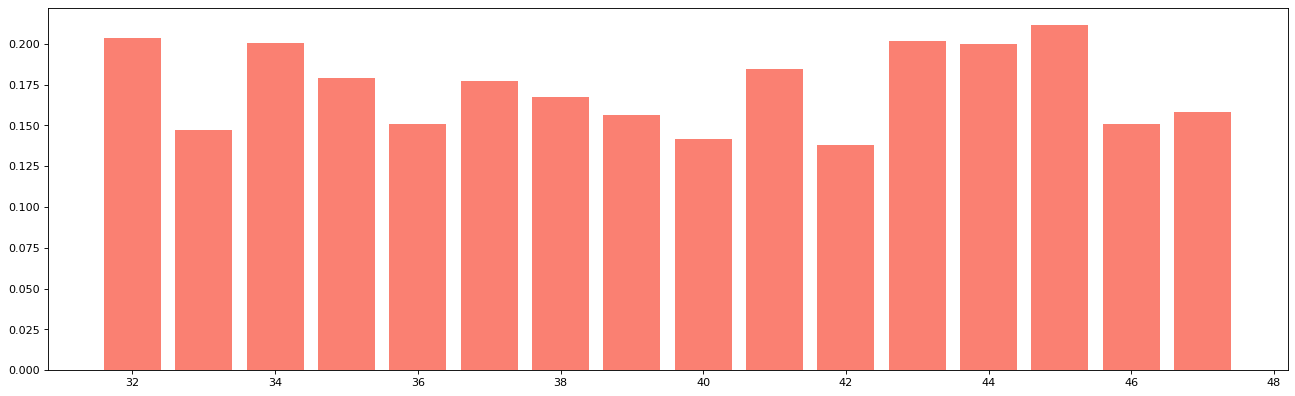

In [19]:
from matplotlib.pyplot import figure

figure(figsize=(20, 6), dpi=80)

x = range(32, 48)
y = accuracies

plt.bar(x, y, color='salmon')
plt.show()

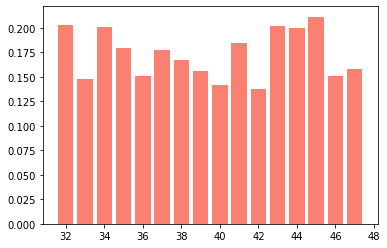

32 0.2034
33 0.1474
34 0.2004
35 0.1791
36 0.1508
37 0.1771
38 0.1673
39 0.1563
40 0.1415
41 0.1842
42 0.1378
43 0.2017
44 0.1997
45 0.2114
46 0.1507
47 0.1582


In [20]:
plt.bar(x, y, color='salmon')
plt.show()
for (i, j) in zip(x, y):
  print(i, j)